In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
from annoy import AnnoyIndex
import torch.autograd as autograd
from typing import List
import anndata
from functools import partial
from copy import deepcopy

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
import math
import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE
import colorcet as cc

import math
from scipy import sparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.utils.weight_norm as weight_norm
import torch.optim.lr_scheduler as lr_scheduler
import scanpy as sc
import time
import os
from scipy import sparse
from adabelief_pytorch import AdaBelief
import torch.quantization

import gzip

from torch.utils.data import WeightedRandomSampler

from utils.explanation_utils import explanation_hook, get_explanation
from sklearn.preprocessing import MinMaxScaler
import gc

torch.cuda.set_device(1)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

from anndata import AnnData
    
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# import warnings
# warnings.filterwarnings("ignore")

path= "../"

# check available files
# !ls ../real_data

torch.autograd.set_detect_anomaly(True)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

########## NEURAL NETWORK UTILITY ##########
cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

CPUTensor =  torch.FloatTensor

In [2]:
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=200, frameon=False, figsize=(3, 3), facecolor='white')

In [3]:
## /acrc/jinmiao/CJM_lab/hoatran/demo_normalization/dataset/dataset5_human_pbmc/raw_data_python/myTotalData.h5ad

In [4]:
adata = sc.read_h5ad("data/COVID_age.h5ad")

# storing the layers count
adata.layers["counts"] = adata.X

In [5]:
adata

AnnData object with n_obs × n_vars = 555976 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'ct', 'sample', 'projectID', 'DataID', 'PatientID', 'Disease_Group', 'Severity', 'Stage', 'Age', 'Sex', 'Race', 'Hospital_Day', 'Days_Symotom_Onset', 'Outcome', 'Tissue', 'Frozen', 'Platform', 'WHO.stage', 'City', 'Country', 'Batch', 'CellType', 'batch', 'batch_num', 'Severity_num', 'n_counts'
    var: 'gene'
    uns: 'CellType_colors', 'Severity_num_colors', 'batch_num_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [6]:
# metadata = adata.obs

# project_list = list(metadata.groupby("projectID").count().sort_values(by = "orig.ident", ascending=False).index[:1].values)

# # project_list

# adata_subset = adata[adata.obs["projectID"].isin(project_list)].copy()
# adata = adata_subset.copy()

In [7]:
# # code to clean out the data with NaN on age
# # got around 1,836,374 cells that including age
# # feasible to used as the dataset

# # (adata.obs.Age > 0).sum()

# # create new h5ad data and mainly focusing on the Age.

# adata_subset = adata[(adata.obs.Age > 0).values].copy()
# removing the NA annotation in the data as we want a proper estimating for different condition
# adata_subset = adata[adata.obs.Severity != "NA"]
# adata_subset.write_h5ad("data/COVID_age.h5ad")

In [8]:
# adata_subset.obs["Severity"]

In [9]:
adata.obs["CellType"] = adata.obs["ct"]

# adata.obs["CellType_tissue"] = adata.obs["CellType"].to_numpy() + adata.obs["tissue"].to_numpy()

adata.obs["batch"] = adata.obs["DataID"]

le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["batch"])
adata.obs["batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["batch_num"] = new_batch

# change also for the groups we want to preserve
le_2 = preprocessing.LabelEncoder()
new_groups = le_2.fit_transform(adata.obs["Severity"])
new_groups = [int(each) for each in new_groups]
# new_groups = [str(each) for each in new_groups]
adata.obs["Severity"] = new_groups

adata.obs["Severity_num"] = le_2.inverse_transform(adata.obs['Severity'])
adata.obs["Severity_num"] = [str(each) for each in adata.obs["Severity_num"]]

In [10]:
adata

AnnData object with n_obs × n_vars = 555976 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'ct', 'sample', 'projectID', 'DataID', 'PatientID', 'Disease_Group', 'Severity', 'Stage', 'Age', 'Sex', 'Race', 'Hospital_Day', 'Days_Symotom_Onset', 'Outcome', 'Tissue', 'Frozen', 'Platform', 'WHO.stage', 'City', 'Country', 'Batch', 'CellType', 'batch', 'batch_num', 'Severity_num', 'n_counts'
    var: 'gene'
    uns: 'CellType_colors', 'Severity_num_colors', 'batch_num_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [11]:
sc.__version__

'1.9.3'

In [12]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

def compute_ari(adata):

    resolutions = None

    if resolutions is None:
        n = 20
        resolutions = [2 * x / n for x in range(1, n + 1)]

    score_max = 0
    res_max = resolutions[0]
    clustering = None
    score_all = []
    use_rep = "X_pca"
    cluster_key = "louvain"
    label_key = "CellType"

    try:
        adata.uns["neighbors"]
    except KeyError:
        if verbose:
            print("computing neighbours for opt_cluster")
        sc.pp.neighbors(adata, use_rep=use_rep)

    for res in resolutions:
        sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
        score = ari(adata, label_key, cluster_key)
        score_all.append(score)
        if score_max < score:
            score_max = score
            res_max = res
            clustering = adata.obs[cluster_key]

    return score_max

In [13]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
#     sc.pp.filter_cells(adata, min_genes=min_genes)
#     sc.pp.filter_genes(adata, min_cells=min_cells)
#     if flavor == 'seurat_v3':
# # #         count data is expected when flavor=='seurat_v3'
# #         sc.pp.highly_variable_genes(
# #             adata, flavor=flavor, batch_key = batch_key)
#         sc.pp.highly_variable_genes(
#             adata, flavor=flavor, batch_key = batch_key, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
#     sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#     sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 5000, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
#     if len(adata.var.index) > n_top_genes:
#         hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [14]:
batch_str = "batch_num"

adata = data_preprocess(adata, batch_str)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...
PreProcess Done.


AnnData object with n_obs × n_vars = 555976 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'ct', 'sample', 'projectID', 'DataID', 'PatientID', 'Disease_Group', 'Severity', 'Stage', 'Age', 'Sex', 'Race', 'Hospital_Day', 'Days_Symotom_Onset', 'Outcome', 'Tissue', 'Frozen', 'Platform', 'WHO.stage', 'City', 'Country', 'Batch', 'CellType', 'batch', 'batch_num', 'Severity_num', 'n_counts'
    var: 'gene'
    uns: 'CellType_colors', 'Severity_num_colors', 'batch_num_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [15]:
adata.layers["log_norm"] = adata.X

In [16]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# check the umap after normalisation

# compute pca and neighbor for calculating the ARI score
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata, n_neighbors=30)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', 'CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

# revert based to unscale data
# adata.X = adata.layers["log_norm"]

In [17]:
# adata

In [18]:
# adata.obs["batch_num"]

In [19]:
# custom_palette = cc.glasbey_category10

# sc.pl.umap(adata, color=['batch_num'], legend_loc = None,
#            palette=custom_palette)

In [20]:
# sc.pl.umap(adata, color=['CellType'],
#            palette=custom_palette)

In [21]:
# sc.pl.umap(adata, color=['Severity_num'],
#            palette=custom_palette)

In [22]:
# sc.pl.umap(adata, color=['projectID'],
#            palette=custom_palette)

In [23]:
# sc.pl.umap(adata, color=['Age'],
#            palette=custom_palette)

In [24]:
# sc.pl.umap(adata, color=['batch_num'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [25]:
# sc.pl.umap(adata, color=['CellType'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [26]:
# # Define the colorcet paletteasdasd
# custom_palette = cc.glasbey_category10

# ax = sc.pl.umap(adata, color='Method', palette=custom_palette,
#            frameon=False, legend_fontsize=3.5, show=False)

# # Set the plot title with the desired font size
# ax.set_title('Predicted Cell Type', fontsize=6)

# # Adjust the legend font size
# handles, labels = plt.gca().get_legend_handles_labels()

# # Adjust the size of the circles
# for handle in handles:
#     handle.set_sizes([12])
#     handle.set_edgecolor('black')
#     handle.set_linewidth(0.5)

# # Move the legend to the right side of the plot
# plt.legend(handles=handles, labels=labels, prop={'size': 5}, ncol = 1, 
#            loc='upper center', bbox_to_anchor=(0.5, -0.08))

# # Show the plot
# plt.show()

In [27]:
from sklearn.preprocessing import OneHotEncoder

# le = preprocessing.LabelEncoder()
enc_batch = OneHotEncoder(handle_unknown='ignore')
enc_group = OneHotEncoder(handle_unknown='ignore')

label_str = "batch"
group_str = "Severity"

enc_batch.fit(adata.obs[label_str].to_numpy().reshape(-1, 1))
enc_group.fit(adata.obs[group_str].to_numpy().reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [28]:
########## CLASS SINGLE CELL DATASET ##########
class ScDataset(Dataset):
    def __init__(self, adata):
        self.variable = None
        self.labels = adata.obs[label_str].to_numpy()
        self.org_batch = adata.obs[label_str].to_numpy()
        self.groups = adata.obs[group_str].to_numpy()
        self.one_hot_labels = enc_batch.transform(adata.obs[label_str].to_numpy().reshape(-1, 1)).toarray()
        self.one_hot_groups = enc_group.transform(adata.obs[group_str].to_numpy().reshape(-1, 1)).toarray()
        try:
            self.X = adata.X.toarray()
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy().toarray()
        except:
            self.X = adata.X
        
        self.min_val = np.amin(adata.X)
        self.max_val = np.amax(adata.X)
#         self.groups = adata.obs[group_str].to_numpy()
        self.transform = None
        self.sample = None
        self.adata = adata
#         self.random_target = np.eye(c_dim)[np.random.choice(c_dim, len(self.labels))]
        
#             self.hvg_X = adata[:, adata.var['highly_variable']].X.copy()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
#         random_index = random.randint(0, self.X.shape[0] - 1)

        return self.X[index], self.labels[index], self.one_hot_labels[index], self.groups[index], self.one_hot_groups[index]

In [29]:
label_str = "batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
anchor_index = np.argmax(length_data)

In [30]:
batches[anchor_index]

104

### pre processing step for normalise and scale the for each individual batch

In [31]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [32]:
adata.X

<555976x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 108200671 stored elements in Compressed Sparse Row format>

## Normalise the sequencing depth which is the library size

The the batch effect removal starting from removing the library size and then remove the actual batch effect from the technical different.

**Previous issue**: we select one batch as the anchor which become and issue when that batch does not seperate cell type well enough as compare to other batch. Hence, we now change to batch free without selecting any anchored batch. 

In [36]:
# import scanpy as sc
# import pandas as pd
# import seaborn as sns

# # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.verbosity = 1
# sc.settings.set_figure_params(
#     dpi=150, frameon=False, figsize=(3, 3), facecolor='white')

# # adata.X = adata.layers["X_scaled"].copy()
# # check the umap after normalisation

# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [37]:
max_val = np.amax(adata.X)
min_val = np.amin(adata.X)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  8.933343461313477
Lower bound of the gene expression:  0.0


In [53]:
def calculate_div_gp(prob_real_data, prob_fake_data, real_data, fake_data, k=2, p=2):
# #     real_data = Variable(real_data, requires_grad=True)
#     prob_real_data, _, = D(real_data)

    real_grad_outputs = torch.ones(prob_real_data.size()).cuda() if cuda else torch.ones(prob_real_data.size())

    fake_data.requires_grad_(True)
#     prob_fake_data, _, = D(fake_data)

    fake_grad_outputs = torch.ones(prob_fake_data.size()).cuda() if cuda else torch.ones(prob_fake_data.size())

    real_gradient = torch.autograd.grad(
        outputs=prob_real_data,
        inputs=real_data,
        grad_outputs=real_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    fake_gradient = torch.autograd.grad(
        outputs=prob_fake_data,
        inputs=fake_data,
        grad_outputs=fake_grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True, 
    )[0]

    real_gradient_norm = real_gradient.view(real_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)
    fake_gradient_norm = fake_gradient.view(fake_gradient.size(0), -1).pow(2).sum(1) ** (p / 2)

    gradient_penalty = torch.mean(real_gradient_norm + fake_gradient_norm) * k / 2
     
    return gradient_penalty 

In [54]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, 0.2)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
#         torch.nn.init.constant_(m.bias.data, 0.0)

In [55]:
class AFF(nn.Module):
    def __init__(self, dim):
        super(AFF, self).__init__()

        # attentional feature fusion layer
        self.sigmoid = nn.Sigmoid()

        self.attention = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Linear(dim, dim),
           # nn.BatchNorm1d(dim),
        )
        
    def forward(self, latent_data, style_latent):
        # fusion layer before decoder
        xa = latent_data + style_latent
        xl = self.attention(xa)
        wei = self.sigmoid(xl)

        data = latent_data * wei + style_latent * ((1 - wei))
        return data

In [56]:
def combine(a, b):
    return torch.cat((a, b), -1)

In [57]:
class GeneExpressionAttention(nn.Module):
    def __init__(self, n_features, d_k, bias = True):
        super(GeneExpressionAttention, self).__init__()
        self.d_k = d_k
        self.bias = bias
        
        # query representation
        self.W_Q = nn.Linear(n_features, d_k, self.bias)
        
        # key and value pair to attend to
        self.W_K = nn.Linear(n_features, d_k, self.bias)
        self.W_V = nn.Linear(n_features, d_k, self.bias)
        
        # multihead attention
#         self.multi_atten = nn.MultiheadAttention(d_k, 4, kdim = n_features, vdim = n_features, batch_first = True)

#         self.encoder = nn.GRU(n_features, d_k, num_layers = 1, bidirectional = False, batch_first = True)

    def forward(self, tabular_data):
        # Project tabular data into Q, K, and V matrices
        Q = self.W_Q(tabular_data)
        K = self.W_K(tabular_data)
        V = self.W_V(tabular_data)
        
        Q, K, V = Q.unsqueeze(1), K.unsqueeze(1), V.unsqueeze(1)
        
#         attn_output, attn_output_weights = self.multi_atten(Q, K, V)
        
#         return attn_output.squeeze(1)

        return F.scaled_dot_product_attention(Q,K,V, is_causal = True).squeeze(1)

In [59]:
from utils.sophia import SophiaG
from utils.acprop import ACProp
# from pytorch_optimizer import *
from adabelief_pytorch import AdaBelief
from pytorch_optimizer import clip_grad_norm

In [60]:
# scaled_X, min_val, max_val = minmax_scale(adata.X)

In [61]:
# adata.X = scaled_X

In [62]:
initial_dropout_rate = 0.8
final_dropout_rate = 0.25
stabilization_epochs = 200
dropout_anneal_epochs = 500 - stabilization_epochs
dropout_decay = (initial_dropout_rate - final_dropout_rate) / dropout_anneal_epochs

# Function to anneal the dropout rate
def anneal_dropout_rate(epoch):
    if epoch < stabilization_epochs:
        return initial_dropout_rate
    else:
        return max(initial_dropout_rate - dropout_decay * (epoch - stabilization_epochs), final_dropout_rate)

In [63]:
from torch.nn.utils.parametrizations import orthogonal

In [64]:
def wasserstein1d(x, y):
    x1, _ = torch.sort(x, dim=0)
    y1, _ = torch.sort(y, dim=0)
    z = (x1-y1).view(-1)
    n = x.size(0)
    return torch.dot(z, z)/n

In [65]:
def normalize_gradient(net_D, x, **kwargs):
    """
                     f
    f_hat = --------------------
            || grad_f || + | f |
    """
    x.requires_grad_(True)
    f, c = net_D(x, **kwargs)
    grad = torch.autograd.grad(
        f, [x], torch.ones_like(f), create_graph=True, retain_graph=True)[0]
    grad_norm = torch.norm(torch.flatten(grad, start_dim=1), p=2, dim=1)
    grad_norm = grad_norm.view(-1, *[1 for _ in range(len(f.shape) - 1)])
    f_hat = (f / (grad_norm + torch.abs(f)))
    return f_hat, c

In [66]:
def train(scd, n_epochs):
#     n_epochs = n_epochss
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_size = scd.X.shape[1]
    lr = 0.0001
    b1 = 0.5
    b2 = 0.999
    latent_dim = 32
#     style_dim = latent_dim
    embedding_dim = 32
    n_dim = 1024
#     proj_dim = 2000
    n_critic = 5
    global c_dim, ctype_dim
    c_dim = len(list(set(adata.obs[label_str])))
    g_dim = len(list(set(adata.obs[group_str])))
    
    # early stopping function
    trigger_times = 0
    best_loss = 100.0
    
    # condition for when we don't have anything to preserve
    con_dim = c_dim
    
    act_func = nn.ReLU(inplace = True)

    class Generator(nn.Module):
        def __init__(self, dropout_rate = 0.1, res_blocks = 3):
                super(Generator, self).__init__()
                self.relu = nn.ReLU(inplace = True)
                self.dropout_rate = dropout_rate
                
                # encoder for the gene expression
                self.encoder = nn.Sequential(
#                     self.proj, # adding projection layer
                    GeneExpressionAttention(data_size + embedding_dim * 2, n_dim),
                    nn.BatchNorm1d(n_dim),
#                     nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2),
                    nn.Linear(n_dim, n_dim // 2),
                    nn.BatchNorm1d(n_dim // 2),
#                     nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2),
                    nn.Linear(n_dim // 2, latent_dim),
#                     nn.BatchNorm1d(latent_dim),
#                     nn.Dropout(self.dropout_rate),
#                     act_func,
                )
                
                # create a share decoder
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, n_dim // 2),
                    nn.BatchNorm1d(n_dim // 2),
#                     nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2),
                    nn.Linear(n_dim // 2, n_dim),
                    nn.BatchNorm1d(n_dim),
#                     nn.Dropout(self.dropout_rate),
                    nn.LeakyReLU(0.2),
                    nn.Linear(n_dim, data_size),
                )
                
                
                self.embedding_layer_c = nn.Sequential(
                    nn.Embedding(c_dim, embedding_dim),
                )
                
                self.embedding_layer_g = nn.Sequential(
                    nn.Embedding(g_dim, embedding_dim),
                )
 
        def forward(self, x, c, g, test = False):
        
            batch_size = x.shape[0]
            # when the model is trained, we discard the c label
            if test == True:
                # zero out to remove this attribute from the model
                c_embeddings = torch.zeros(batch_size, embedding_dim, device = x.device)
            else:
                c_embeddings = self.embedding_layer_c(c)
            
            g_embeddings = self.embedding_layer_g(g)
            data = torch.cat((x, c_embeddings, g_embeddings), -1)
            
#             out_proj = self.proj(data)
#             atten_out = self.atten_out(data) + self.random_atten_out(data)
        
            # content network
            latent_data = self.encoder(data)
#             latent_data = self.resnet(latent_data)
            corrected_data = self.decoder(latent_data)
#             atten_corrected = self.decoder(atten_out)
            
            return corrected_data
    
    class Discriminator(nn.Module):
        def __init__(self, dropout_rate = 0.1):
            super(Discriminator, self).__init__()
            
#             self.self_att = nn.Sequential(
#                     GeneExpressionAttention(data_size, embedding_dim),
#                     LinearAttention(embedding_dim, embedding_dim),
#             )
            
            self.dropout_rate = dropout_rate
            
            self.model = nn.Sequential(
                GeneExpressionAttention(data_size, n_dim), # adding projection layer
                nn.BatchNorm1d(n_dim),
                nn.Dropout(self.dropout_rate),
                nn.LeakyReLU(0.2),
                nn.Linear(n_dim, n_dim // 2),
                nn.BatchNorm1d(n_dim // 2),
                nn.Dropout(self.dropout_rate),
                nn.LeakyReLU(0.2),
                nn.Linear(n_dim // 2, latent_dim),
                nn.BatchNorm1d(latent_dim),
                nn.LeakyReLU(0.2),
            )
            
            # Output layers
            self.adv_layer = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(latent_dim, 1)
                ) for _ in range(c_dim + g_dim)
            ])
            
            # Classify layers
            self.cls_layer_c = nn.Sequential(
                nn.Linear(latent_dim, c_dim),
            )
            
            # classifying groups
            self.cls_layer_g = nn.Sequential(
                nn.Linear(latent_dim, g_dim),
            )

        def forward(self, data):
          #  data = torch.cat((data, label), -1)
#             atten = self.self_att(data)
            out = self.model(data)
#             out = self.residual(out)
            # shortcut connection with attention embeddings
#             out = combine(out, atten)
            validity = [adv(out) for adv in self.adv_layer]
            classify_c = self.cls_layer_c(out)
            classify_g = self.cls_layer_g(out)
            return validity, classify_c, classify_g

    # Initialize generator and discriminator
    G_AB = Generator()
    D_B = Discriminator()
#     D_latent = Discriminator_latent()
    
    target = [int(x) for x in scd.org_batch]
    
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, 60000)

    dataloader = DataLoader(
        dataset = scd,
        batch_size=4096,
        shuffle=False, sampler = sampler
    )

    criterion_cycle = nn.SmoothL1Loss(reduction = "mean")
#     criterion_batch = KLLossBatches()
#     criterion_match = MMDLoss()
#     criterion_similar = EfficientSupConLoss()
#     criterion_batch_fake = JSLossBatches()
#     criterion_cycle_dist = CombineLoss()
    
    def criterion_cls(logit, target):
        return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)
    
    # Define the loss function and optimizer
    criterion_c = criterion_cls
    criterion_g = criterion_cls
#     loss_fn = nn.BCEWithLogitsLoss()
#     criterion_mixing = nn.CrossEntropyLoss(label_smoothing=0.0)
#     criterion_c_latent = nn.CrossEntropyLoss(label_smoothing=0.0)
#     crtierion_div = DistributionMinimization()
#     criterion_g = nn.CrossEntropyLoss()
    
#     criterion_cls = SGVLB(D_B, len(dataloader.dataset), F.binary_cross_entropy_with_logits)
    
    def l1_norm(x):
        return torch.mean(torch.abs(x))

    # Loss weights
    lambda_cls = 1
    lambda_rec = 10
    lambda_gp = 1
    
#     lambda_style = 5
    lambda_adv = 1
    
    if cuda:
        G_AB.cuda()
        D_B.cuda()
#         D_latent.cuda()
        criterion_cycle.cuda()
#         loss_fn.cuda()
#         criterion_similar.cuda()
#         criterion_c.cuda()
#         criterion_mixing.cuda()
#         criterion_match.cuda()
#         criterion_batch.cuda()
#         criterion_c_latent.cuda()
    
    # Initialize weights
    G_AB.apply(weights_init_normal)
    D_B.apply(weights_init_normal)
    
    # adding optimiser
#     optimizer_G_AB = torch.optim.Adam(G_AB.parameters(), lr=lr, betas=(b1, b2)) # can add W to adam
#     optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))
    
    # weight decay parameter is the same as AdamW
    optimizer_G_AB = ACProp(G_AB.parameters(), lr=lr, betas=(b1, b2), eps=1e-16, weight_decouple = True, rectify = True, amsgrad = True, weight_decay = 0)  
    optimizer_D_B = ACProp(D_B.parameters(), lr=lr, betas=(b1, b2), eps=1e-16, weight_decouple = True, rectify = True, amsgrad = True, weight_decay = 0)
    
    start_time = time.time()

    G_AB.train()
    D_B.train()
    
    def generate_data(G_AB, imgs, sampled_c, sampled_g):
        fake_imgs = G_AB(imgs, sampled_c, sampled_g)
        fake_imgs = F.relu(imgs - fake_imgs)
        return fake_imgs
    
    def get_adv_loss(valid):
        adv_loss = 0
        for i in range(c_dim + g_dim):
            adv_loss += torch.mean(valid[i])
        return adv_loss
    
    def get_adv(valid):
        adv_loss = 0
        for i in range(c_dim + g_dim):
            adv_loss += valid[i]
        return adv_loss

    for epoch in range(n_epochs):
        
#         if (epoch - 1) == explanationSwitch:
# #             def print_grad(module, grad_input, grad_output):
# #                 print(grad_input[0].shape)
#             G_AB.register_backward_hook(explanation_hook)
#             local_explainable = True
#         kl_weight = min(kl_weight+0.02, 1)

        # Anneal the dropout rate for the current epoch
#         dropout_rate = anneal_dropout_rate(epoch)
#         G_AB.apply(lambda module: setattr(module, "dropout_rate", dropout_rate))
#         D_B.apply(lambda module: setattr(module, "dropout_rate", dropout_rate))
        
        for i, (X, labels, one_hot_labels, groups, one_hot_groups) in enumerate(dataloader):
            batch_size = X.shape[0]

            # Model inputs
            imgs = Variable(X.type(FloatTensor), requires_grad=True)       
            labels = Variable(labels.type(LongTensor))
            one_hot_labels = Variable(one_hot_labels.type(FloatTensor))
            
            groups = Variable(groups.type(LongTensor))
            one_hot_groups = Variable(one_hot_groups.type(FloatTensor))
#             fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

            # Sample labels as generator inputs
#             sampled_c = Variable(FloatTensor(np.random.randint(0, 2, (imgs.size(0), c_dim))))
            sampled_c = Variable(LongTensor(np.random.choice(c_dim, batch_size).astype('long')))
            sampled_g = Variable(LongTensor(np.random.choice(g_dim, batch_size).astype('long')))
#             sampled_c_2 = Variable(LongTensor(np.random.choice(c_dim, batch_size).astype('long')))
#             sampled_g = Variable(LongTensor(np.random.choice(g_dim, batch_size).astype('long')))
#             sampled_c = Variable(sampled_c.type(FloatTensor))

            # Generate fake batch of images
            # adding noise to the generated images
            fake_imgs = generate_data(G_AB, imgs, sampled_c, sampled_g)
            
            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D_B.zero_grad()
#             optimizer_D_latent.zero_grad()
#             optimizer_G_AB.zero_grad()
            
            # real images
            real_validity, pred_c, pred_g = D_B(imgs)
            # Fake images
            fake_validity, _, _ = D_B(fake_imgs)
            # gradient penalty
#             gradient_penalty = calculate_gradient_penalty(imgs.data, fake_imgs.data, D_B)
            gradient_penalty = calculate_div_gp(get_adv(real_validity), get_adv(fake_validity), imgs, fake_imgs)
    
            # Adversarial loss
#             real_validity = penalty_normalize_gradient(D_B, imgs)
#             fake_validity = penalty_normalize_gradient(D_B, fake_imgs)
            
            loss_D_adv = -get_adv_loss(real_validity) + get_adv_loss(fake_validity) + gradient_penalty
             
#             combined_input = combine(imgs, G_AB.embedding_layer_c(labels))
            
#             real_imgs_latent = G_AB.encoder(combined_input) + G_AB.atten_out(combined_input) + G_AB.random_atten_out(combined_input)
            
            # Classification loss
#             loss_D_cls = criterion_c(pred_c, labels) + criterion_c_latent(D_latent(real_imgs_latent), labels)
            loss_D_cls = criterion_c(pred_c, one_hot_labels) + criterion_g(pred_g, one_hot_groups)
            
            # total Loss
            loss_D = lambda_adv * loss_D_adv + lambda_cls * (loss_D_cls)
#             loss_D = lambda_adv * loss_D_adv + lambda_cls * loss_D_cls
            
#             scaler_D.scale(loss_D).backward()
#             scaler_D.step(optimizer_D_B)
#             scaler_D.update()
            
            loss_D.backward()
#             clip_grad_norm(loss_D)
            optimizer_D_B.step()
            
#             for p in D_B.parameters():
#                 p.data.clamp_(-2.0, 2.0)
#             optimizer_D_latent.step()
            
            # -----------------
            #  Train Generator
            # -----------------
            
            
            if i % n_critic == 0:
                
                optimizer_G_AB.zero_grad()
                # Translate and reconstruct image
                # adding noise again
                gen_imgs = generate_data(G_AB, imgs, sampled_c, sampled_g)
                recov_imgs = generate_data(G_AB, gen_imgs, labels, groups)
                
                # Discriminator evaluates translated image
                fake_validity, pred_c_2, pred_g_2 = D_B(gen_imgs)
            
                loss_G_adv = -get_adv_loss(fake_validity)
            
                # classification loss
                loss_G_cls = criterion_c(pred_c_2, F.one_hot(sampled_c, c_dim).float()) + criterion_g(pred_g_2, F.one_hot(sampled_g, g_dim).float())
                
                # Cycle consistency Reconstruction loss
                loss_G_rec = criterion_cycle(recov_imgs, imgs)
                
                # total loss
                loss_G = lambda_adv * loss_G_adv + lambda_rec * loss_G_rec + lambda_cls * (loss_G_cls)
                loss_G.backward()
#                 clip_grad_norm(loss_G)
                optimizer_G_AB.step()


                # --------------
                #  Log Progress
                # --------------

            # Determine approximate time left
            batches_done = epoch * len(dataloader) + i
            batches_left = n_epochs * len(dataloader) - batches_done
            time_left = datetime.timedelta(
                seconds=batches_left * (time.time() - start_time) / (batches_done + 1))

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, cls: %f, cycle: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(dataloader),
                loss_D_adv.item(),
                loss_D_cls.item(),
                loss_G.item(),
                loss_G_adv.item(),
                loss_G_cls.item(),
                loss_G_rec.item(),
#                 loss_G_mse.item(),
                time_left,
            )
        )
        #################
        # implement early stopping for 10 iterations
        ###################
        
        # need to train the model at least 500 epochs first
#         if epoch < 1200:
#             continue
        
#         monitor_loss = loss_G_cls.item()
        
#         if monitor_loss > best_loss:
#             trigger_times += 1
            
#             if trigger_times > 30:
#                 return G_AB_best, D_B_best
            
# #             print(trigger_times)
            
#         else:
#             best_loss = monitor_loss
#             trigger_times = 0
#             G_AB_best = G_AB
#             D_B_best = D_B
        
#         if monitor_loss > best_loss + 0.5:
#             best_loss = 100.0 # reset best loss function when the fluctuation is too strong
        
#         if best_score < loss_G_adv.item():
#             G_AB_best = G_AB
#             best_score = loss_G_adv.item()
        gc.collect()
        torch.cuda.empty_cache()
        
    return G_AB, D_B

In [67]:
### Stage II

seed = 8
n_epochs = 480

adata.obs["batch"] = [int(each) for each in adata.obs["batch"]]
# adata.obs["organ_tissue"] = [int(each) for each in adata.obs["organ_tissue"]]

scd = ScDataset(adata)

# output_results, scd = integrate_data(adata, key = batch_str, inc=True, n_epochs=5, n_batch = n_classes) #inc = True for multi-batch

setup_seed(seed)

print('Adata Info: ')
print(adata)

G_AB, D_B = train(scd, n_epochs=n_epochs)

Adata Info: 
AnnData object with n_obs × n_vars = 555976 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'ct', 'sample', 'projectID', 'DataID', 'PatientID', 'Disease_Group', 'Severity', 'Stage', 'Age', 'Sex', 'Race', 'Hospital_Day', 'Days_Symotom_Onset', 'Outcome', 'Tissue', 'Frozen', 'Platform', 'WHO.stage', 'City', 'Country', 'Batch', 'CellType', 'batch', 'batch_num', 'Severity_num', 'n_counts'
    var: 'gene'
    uns: 'CellType_colors', 'Severity_num_colors', 'batch_num_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
AMSGrad enabled in AdaBelief
Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
AMSGrad enabled in AdaBelief


/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Epoch 0/480] [Batch 14/15] [D adv: 0.045309, aux: 86.457512] [G loss: 86.852531, adv: 0.380731, cls: 86.464729, cycle: 0.000707] ETA: 1:44:22.181756
[Epoch 1/480] [Batch 14/15] [D adv: 0.018062, aux: 86.343498] [G loss: 86.773460, adv: 0.399119, cls: 86.367287, cycle: 0.000706] ETA: 1:47:03.336840
[Epoch 2/480] [Batch 14/15] [D adv: 0.010178, aux: 86.121239] [G loss: 86.611946, adv: 0.431995, cls: 86.172989, cycle: 0.000696] ETA: 1:48:32.113293
[Epoch 3/480] [Batch 14/15] [D adv: 0.005913, aux: 85.736580] [G loss: 86.321114, adv: 0.480701, cls: 85.833595, cycle: 0.000681] ETA: 1:48:38.805619
[Epoch 4/480] [Batch 14/15] [D adv: 0.003930, aux: 85.010605] [G loss: 85.769188, adv: 0.570777, cls: 85.191803, cycle: 0.000661] ETA: 1:48:57.197750
[Epoch 5/480] [Batch 14/15] [D adv: 0.002886, aux: 83.583885] [G loss: 84.654335, adv: 0.698488, cls: 83.949486, cycle: 0.000636] ETA: 1:48:49.801335
[Epoch 6/480] [Batch 14/15] [D adv: 0.002332, aux: 80.907341] [G loss: 82.428322, adv: 0.844120, cls

[Epoch 55/480] [Batch 14/15] [D adv: -0.183211, aux: 6.660523] [G loss: 5.680492, adv: -0.965164, cls: 6.624854, cycle: 0.002080] ETA: 1:40:13.666851
[Epoch 56/480] [Batch 14/15] [D adv: -0.182107, aux: 6.631881] [G loss: 5.880064, adv: -0.787566, cls: 6.647597, cycle: 0.002003] ETA: 1:39:58.724352
[Epoch 57/480] [Batch 14/15] [D adv: -0.178743, aux: 6.608624] [G loss: 5.994875, adv: -0.673404, cls: 6.647861, cycle: 0.002042] ETA: 1:39:45.833694
[Epoch 58/480] [Batch 14/15] [D adv: -0.217071, aux: 6.556332] [G loss: 6.067089, adv: -0.594422, cls: 6.641052, cycle: 0.002046] ETA: 1:39:33.687506
[Epoch 59/480] [Batch 14/15] [D adv: -0.183097, aux: 6.487944] [G loss: 6.161233, adv: -0.459976, cls: 6.601717, cycle: 0.001949] ETA: 1:39:20.440795
[Epoch 60/480] [Batch 14/15] [D adv: -0.221829, aux: 6.463913] [G loss: 6.316386, adv: -0.302612, cls: 6.599092, cycle: 0.001991] ETA: 1:39:06.823538
[Epoch 61/480] [Batch 14/15] [D adv: -0.194383, aux: 6.417361] [G loss: 6.506507, adv: -0.101991, cl

[Epoch 110/480] [Batch 14/15] [D adv: -1.755347, aux: 4.981753] [G loss: 13.877370, adv: 7.166173, cls: 6.667729, cycle: 0.004347] ETA: 1:27:04.543654
[Epoch 111/480] [Batch 14/15] [D adv: -2.163763, aux: 4.938906] [G loss: 14.080706, adv: 7.443841, cls: 6.595566, cycle: 0.004130] ETA: 1:26:48.387199
[Epoch 112/480] [Batch 14/15] [D adv: -1.645990, aux: 4.914017] [G loss: 13.814878, adv: 7.005171, cls: 6.761236, cycle: 0.004847] ETA: 1:26:34.570796
[Epoch 113/480] [Batch 14/15] [D adv: -0.723782, aux: 4.890578] [G loss: 14.449175, adv: 7.720235, cls: 6.686385, cycle: 0.004255] ETA: 1:26:18.866605
[Epoch 114/480] [Batch 14/15] [D adv: -1.503585, aux: 4.912791] [G loss: 14.109391, adv: 7.352625, cls: 6.714090, cycle: 0.004268] ETA: 1:26:03.047097
[Epoch 115/480] [Batch 14/15] [D adv: -0.156148, aux: 4.875101] [G loss: 13.834511, adv: 6.869899, cls: 6.904489, cycle: 0.006012] ETA: 1:25:47.511797
[Epoch 116/480] [Batch 14/15] [D adv: -0.473130, aux: 4.913661] [G loss: 13.968701, adv: 7.226

[Epoch 165/480] [Batch 14/15] [D adv: -1.996107, aux: 4.232821] [G loss: 7.843577, adv: 2.374441, cls: 5.375142, cycle: 0.009399] ETA: 1:15:32.244855
[Epoch 166/480] [Batch 14/15] [D adv: -2.029102, aux: 4.201984] [G loss: 7.383905, adv: 1.941403, cls: 5.350043, cycle: 0.009246] ETA: 1:15:20.438153
[Epoch 167/480] [Batch 14/15] [D adv: -2.443645, aux: 4.200640] [G loss: 7.580347, adv: 2.088449, cls: 5.395331, cycle: 0.009657] ETA: 1:15:09.745761
[Epoch 168/480] [Batch 14/15] [D adv: -1.516261, aux: 4.209377] [G loss: 7.329188, adv: 1.934214, cls: 5.295673, cycle: 0.009930] ETA: 1:14:57.237035
[Epoch 169/480] [Batch 14/15] [D adv: -2.623779, aux: 4.306262] [G loss: 7.188436, adv: 1.789456, cls: 5.302468, cycle: 0.009651] ETA: 1:14:45.929828
[Epoch 170/480] [Batch 14/15] [D adv: -1.360899, aux: 4.209731] [G loss: 6.187323, adv: 0.807968, cls: 5.279955, cycle: 0.009940] ETA: 1:14:34.648361
[Epoch 171/480] [Batch 14/15] [D adv: -0.707092, aux: 4.295021] [G loss: 5.774053, adv: 0.375908, cl

[Epoch 220/480] [Batch 14/15] [D adv: -1.500050, aux: 3.939663] [G loss: -0.569890, adv: -4.606909, cls: 3.919705, cycle: 0.011731] ETA: 1:02:36.064595
[Epoch 221/480] [Batch 14/15] [D adv: -3.143714, aux: 3.909878] [G loss: 0.500809, adv: -3.615050, cls: 4.000641, cycle: 0.011522] ETA: 1:02:20.950998
[Epoch 222/480] [Batch 14/15] [D adv: -3.926816, aux: 3.955913] [G loss: 2.374858, adv: -1.743484, cls: 3.998811, cycle: 0.011953] ETA: 1:02:06.028453
[Epoch 223/480] [Batch 14/15] [D adv: -5.263697, aux: 3.929806] [G loss: 2.657897, adv: -1.343662, cls: 3.880557, cycle: 0.012100] ETA: 1:01:51.164286
[Epoch 224/480] [Batch 14/15] [D adv: 9.259601, aux: 4.118567] [G loss: 2.878802, adv: -1.127540, cls: 3.885698, cycle: 0.012064] ETA: 1:01:36.507064
[Epoch 225/480] [Batch 14/15] [D adv: -0.189306, aux: 4.010088] [G loss: -0.751118, adv: -4.782379, cls: 3.915736, cycle: 0.011552] ETA: 1:01:22.006043
[Epoch 226/480] [Batch 14/15] [D adv: -0.312299, aux: 3.890731] [G loss: -0.828652, adv: -4.9

[Epoch 274/480] [Batch 14/15] [D adv: -0.238661, aux: 4.235250] [G loss: -16.567776, adv: -20.060366, cls: 3.361660, cycle: 0.013093] ETA: 0:49:43.358828
[Epoch 275/480] [Batch 14/15] [D adv: -0.246697, aux: 4.206463] [G loss: -16.651634, adv: -20.151888, cls: 3.372775, cycle: 0.012748] ETA: 0:49:31.160911
[Epoch 276/480] [Batch 14/15] [D adv: -0.258564, aux: 4.145646] [G loss: -16.734280, adv: -20.215963, cls: 3.357688, cycle: 0.012399] ETA: 0:49:19.543963
[Epoch 277/480] [Batch 14/15] [D adv: -0.218035, aux: 4.168572] [G loss: -16.816578, adv: -20.288832, cls: 3.350698, cycle: 0.012156] ETA: 0:49:07.811207
[Epoch 278/480] [Batch 14/15] [D adv: -0.311352, aux: 4.170341] [G loss: -16.879196, adv: -20.321766, cls: 3.322420, cycle: 0.012015] ETA: 0:48:55.537485
[Epoch 279/480] [Batch 14/15] [D adv: -0.305182, aux: 4.102717] [G loss: -16.943045, adv: -20.371510, cls: 3.310262, cycle: 0.011820] ETA: 0:48:41.355323
[Epoch 280/480] [Batch 14/15] [D adv: -0.348011, aux: 4.169584] [G loss: -16

[Epoch 328/480] [Batch 14/15] [D adv: -0.562208, aux: 3.807469] [G loss: -16.685463, adv: -19.742706, cls: 2.970715, cycle: 0.008653] ETA: 0:36:42.833403
[Epoch 329/480] [Batch 14/15] [D adv: -0.595989, aux: 3.653397] [G loss: -16.657738, adv: -19.622137, cls: 2.877326, cycle: 0.008707] ETA: 0:36:28.028420
[Epoch 330/480] [Batch 14/15] [D adv: -0.614001, aux: 3.760476] [G loss: -16.580309, adv: -19.588236, cls: 2.921841, cycle: 0.008609] ETA: 0:36:13.160226
[Epoch 331/480] [Batch 14/15] [D adv: -0.664884, aux: 3.587912] [G loss: -16.607296, adv: -19.669199, cls: 2.974750, cycle: 0.008715] ETA: 0:35:58.499194
[Epoch 332/480] [Batch 14/15] [D adv: -0.514564, aux: 3.740947] [G loss: -16.638386, adv: -19.604782, cls: 2.880635, cycle: 0.008576] ETA: 0:35:43.624985
[Epoch 333/480] [Batch 14/15] [D adv: -0.633042, aux: 3.689025] [G loss: -16.847219, adv: -19.847439, cls: 2.913641, cycle: 0.008658] ETA: 0:35:28.850529
[Epoch 334/480] [Batch 14/15] [D adv: -0.585801, aux: 3.629982] [G loss: -16

[Epoch 382/480] [Batch 14/15] [D adv: -0.864276, aux: 3.512124] [G loss: -16.870131, adv: -19.540865, cls: 2.581216, cycle: 0.008952] ETA: 0:23:36.327545
[Epoch 383/480] [Batch 14/15] [D adv: -0.396984, aux: 3.455053] [G loss: -16.675243, adv: -19.336582, cls: 2.570796, cycle: 0.009054] ETA: 0:23:21.536531
[Epoch 384/480] [Batch 14/15] [D adv: -1.709149, aux: 3.498086] [G loss: -16.560364, adv: -19.219938, cls: 2.567374, cycle: 0.009220] ETA: 0:23:06.754157
[Epoch 385/480] [Batch 14/15] [D adv: -1.982644, aux: 3.389961] [G loss: -16.219830, adv: -18.824116, cls: 2.512514, cycle: 0.009177] ETA: 0:22:51.993903
[Epoch 386/480] [Batch 14/15] [D adv: -0.452500, aux: 3.434184] [G loss: -16.253492, adv: -18.837015, cls: 2.491676, cycle: 0.009185] ETA: 0:22:37.159312
[Epoch 387/480] [Batch 14/15] [D adv: -1.552065, aux: 3.367478] [G loss: -16.602415, adv: -19.206844, cls: 2.512039, cycle: 0.009239] ETA: 0:22:22.376492
[Epoch 388/480] [Batch 14/15] [D adv: -0.048701, aux: 3.478886] [G loss: -16

[Epoch 436/480] [Batch 14/15] [D adv: -2.987746, aux: 3.177005] [G loss: -16.442549, adv: -18.930075, cls: 2.391890, cycle: 0.009564] ETA: 0:10:28.123941
[Epoch 437/480] [Batch 14/15] [D adv: -0.266925, aux: 3.258065] [G loss: -16.503269, adv: -18.981197, cls: 2.384388, cycle: 0.009354] ETA: 0:10:13.531525
[Epoch 438/480] [Batch 14/15] [D adv: -0.556310, aux: 3.248106] [G loss: -17.478449, adv: -19.884329, cls: 2.310073, cycle: 0.009581] ETA: 0:09:58.925265
[Epoch 439/480] [Batch 14/15] [D adv: -0.599233, aux: 3.348837] [G loss: -17.379879, adv: -19.858194, cls: 2.383618, cycle: 0.009470] ETA: 0:09:44.325115
[Epoch 440/480] [Batch 14/15] [D adv: -0.869901, aux: 3.243086] [G loss: -17.190336, adv: -19.592920, cls: 2.307267, cycle: 0.009532] ETA: 0:09:29.745531
[Epoch 441/480] [Batch 14/15] [D adv: -2.667362, aux: 3.218859] [G loss: -16.485313, adv: -18.950777, cls: 2.368782, cycle: 0.009668] ETA: 0:09:15.143140
[Epoch 442/480] [Batch 14/15] [D adv: -0.281962, aux: 3.187909] [G loss: -18

In [68]:
# writer.close()

In [91]:
# for saving good model

# torch.save(G_AB.state_dict(), 'Generator_rom_pbmc.pth')
# G_AB.load_state_dict(torch.load('Generator_rom_pancreatic.pth'))

# torch.save(D_B.state_dict(), 'Discriminator_rom_COVID.pth')
# D_B.load_state_dict(torch.load('Discriminator_rom_pancreatic.pth'))


# transfer to GPU for Making prediction
# G_AB.cuda()
# D_B.cuda()

In [70]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1

sc.settings.set_figure_params(
    dpi=300, frameon=False, figsize=(3, 3), facecolor='white')

# new_groups = [str(each) for each in new_groups]
new_batch = [str(each) for each in new_batch]

# adata.X = sc.pp.normalize_per_cell(adata.X, copy = True, counts_per_cell_after=1e4, min_counts=0)
# adata.X = sc.pp.log1p(adata.X)
# # observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)

# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['Batch', 'celltype'],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [76]:
G_AB.cpu()

Generator(
  (relu): ReLU(inplace=True)
  (encoder): Sequential(
    (0): GeneExpressionAttention(
      (W_Q): Linear(in_features=5064, out_features=1024, bias=True)
      (W_K): Linear(in_features=5064, out_features=1024, bias=True)
      (W_V): Linear(in_features=5064, out_features=1024, bias=True)
    )
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024,

In [77]:
G_AB.eval()

# anchor_index_oh = enc_batch.transform(np.array([batches[anchor_index]]).reshape(-1, 1)).toarray()[0].tolist().index(1.0)

with torch.no_grad():
    imgs = Variable(CPUTensor(scd.X))
    src_labels = Variable(LongTensor(scd.labels))
#     trg_labels = Variable(LongTensor(np.random.choice(c_dim, src_labels.size(0)).astype('long')))
    groups = Variable(LongTensor(scd.groups))
    
    static_sample = G_AB(imgs.cpu(), torch.ones(imgs.size()[0]).long(), groups.cpu(), test = True)
    static_sample =  F.relu(CPUTensor(scd.X - static_sample.detach().numpy())).detach().numpy()
    
output_results = static_sample

In [78]:
# output_results = adata.X

max_val = np.amax(output_results)
min_val = np.amin(output_results)

print("Upper bound of the gene expression: ", max_val)
print("Lower bound of the gene expression: ", min_val)

Upper bound of the gene expression:  14.619703
Lower bound of the gene expression:  0.0


In [79]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(output_results)

X_pca = pca.transform(output_results)

adata.obsm["X_pca"] = X_pca.copy()

In [80]:
adata.obs["batch"] = [str(each) for each in adata.obs["batch"]]
# adata.obs["organ_tissue"] = [str(each) for each in adata.obs["organ_tissue"]]

In [81]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/umap/distances.

In [82]:
custom_palette = cc.glasbey_category10

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


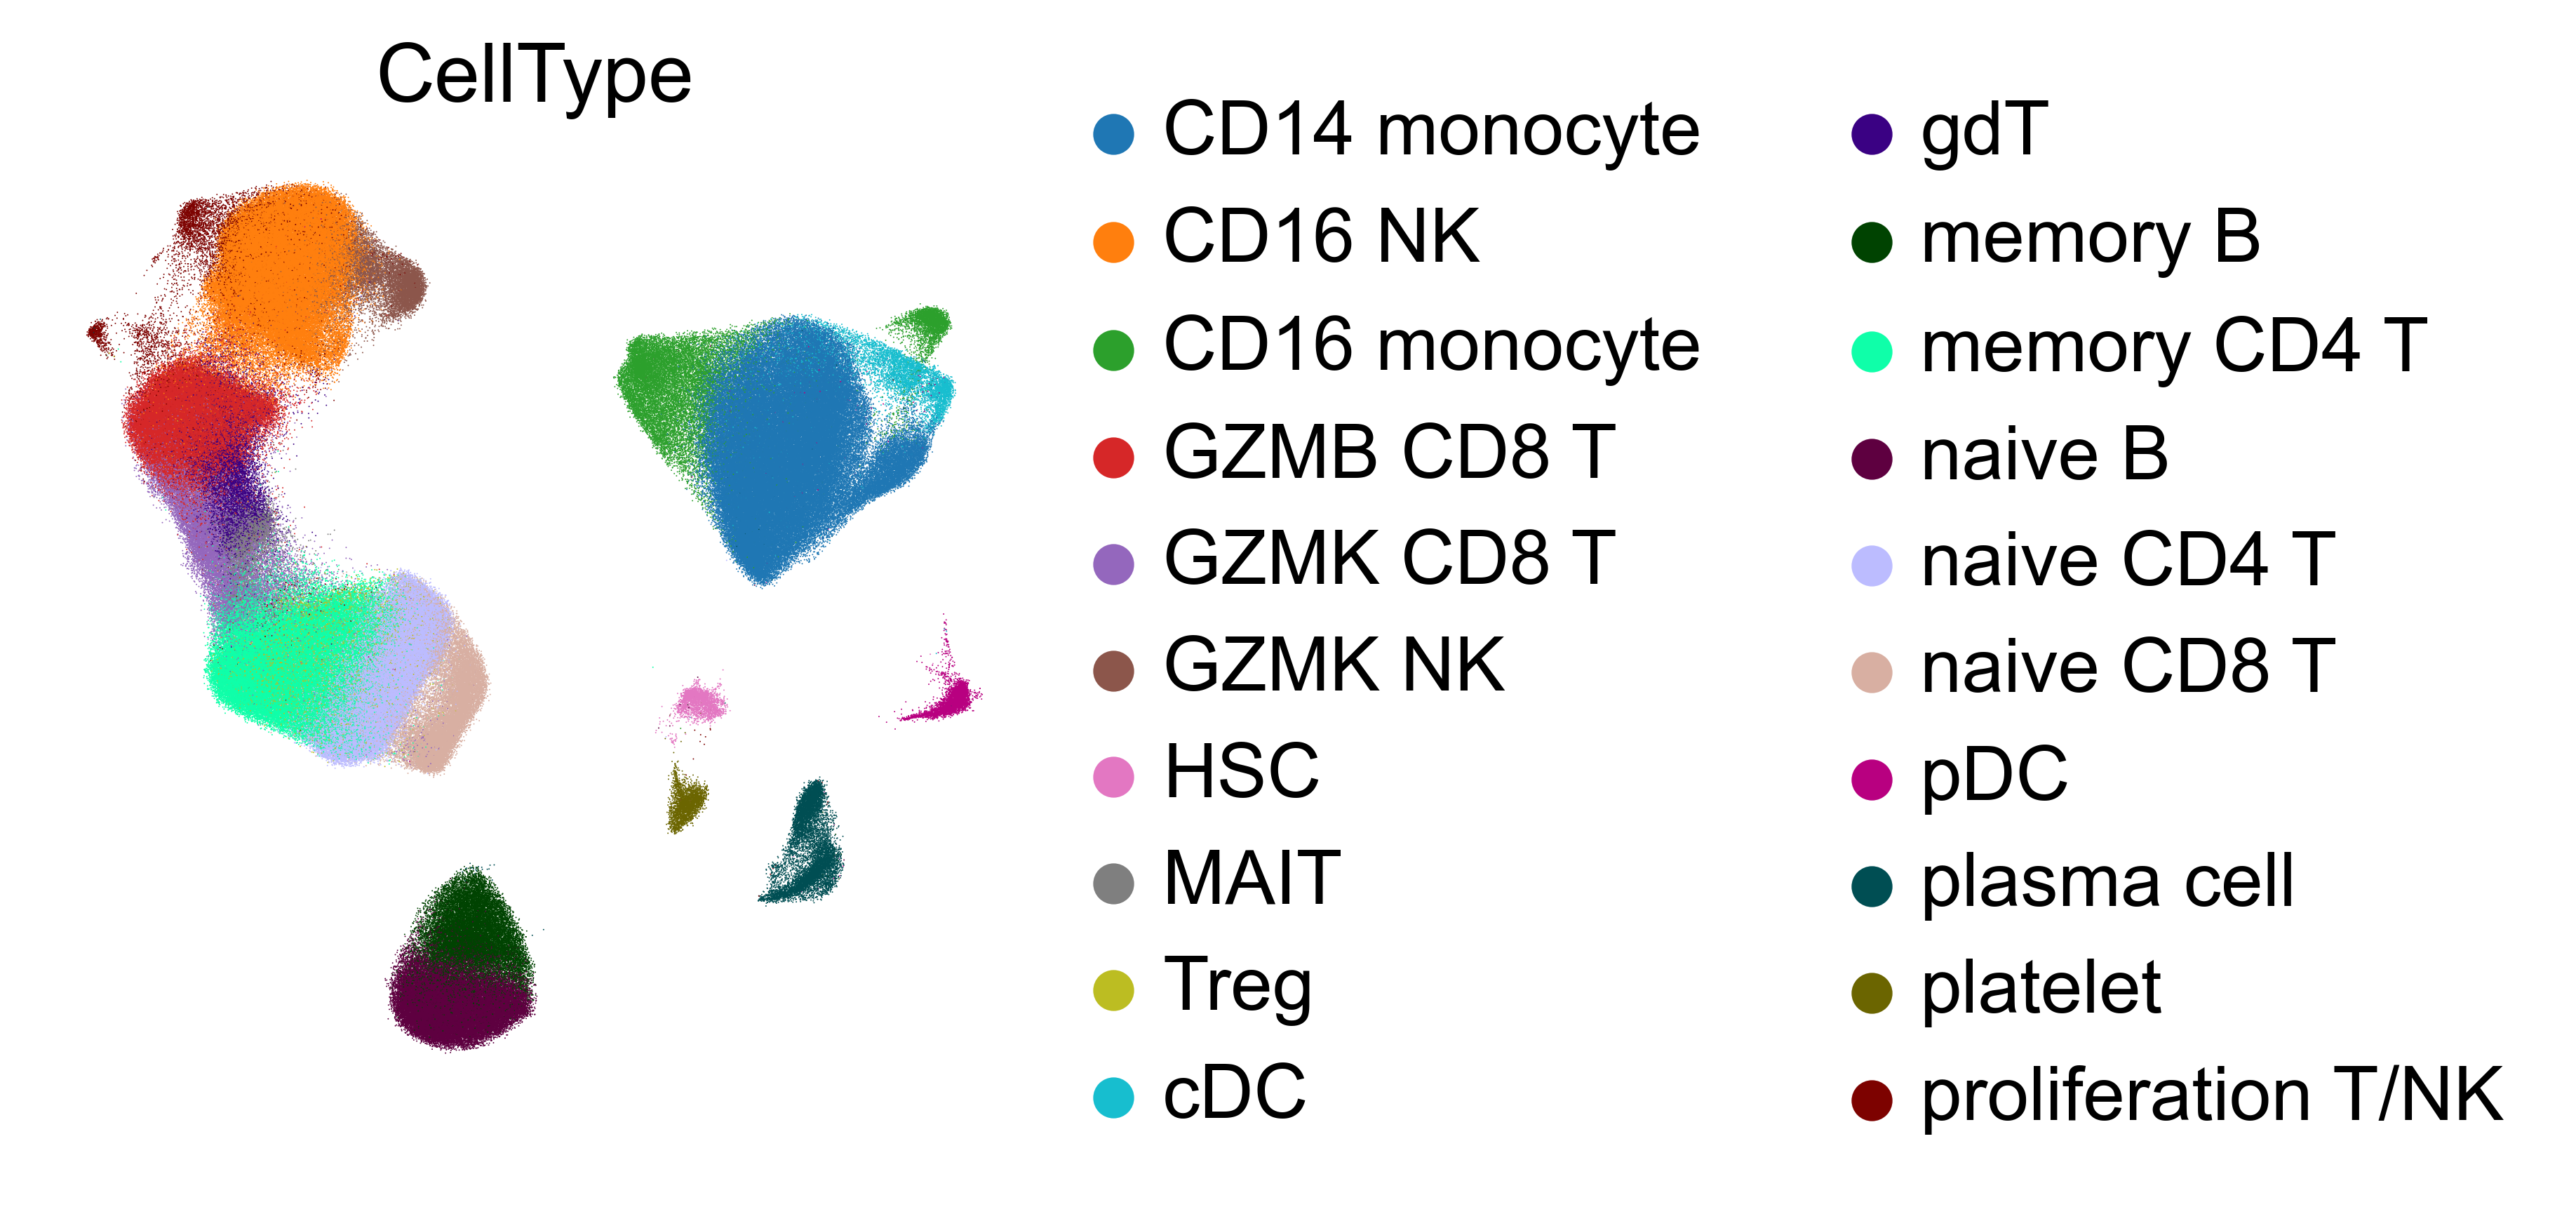

In [83]:
# adata.obsm["X_latent"] = output_results

# sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# sc.tl.umap(adata)
sc.pl.umap(adata, color=["CellType"], 
           palette=custom_palette)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


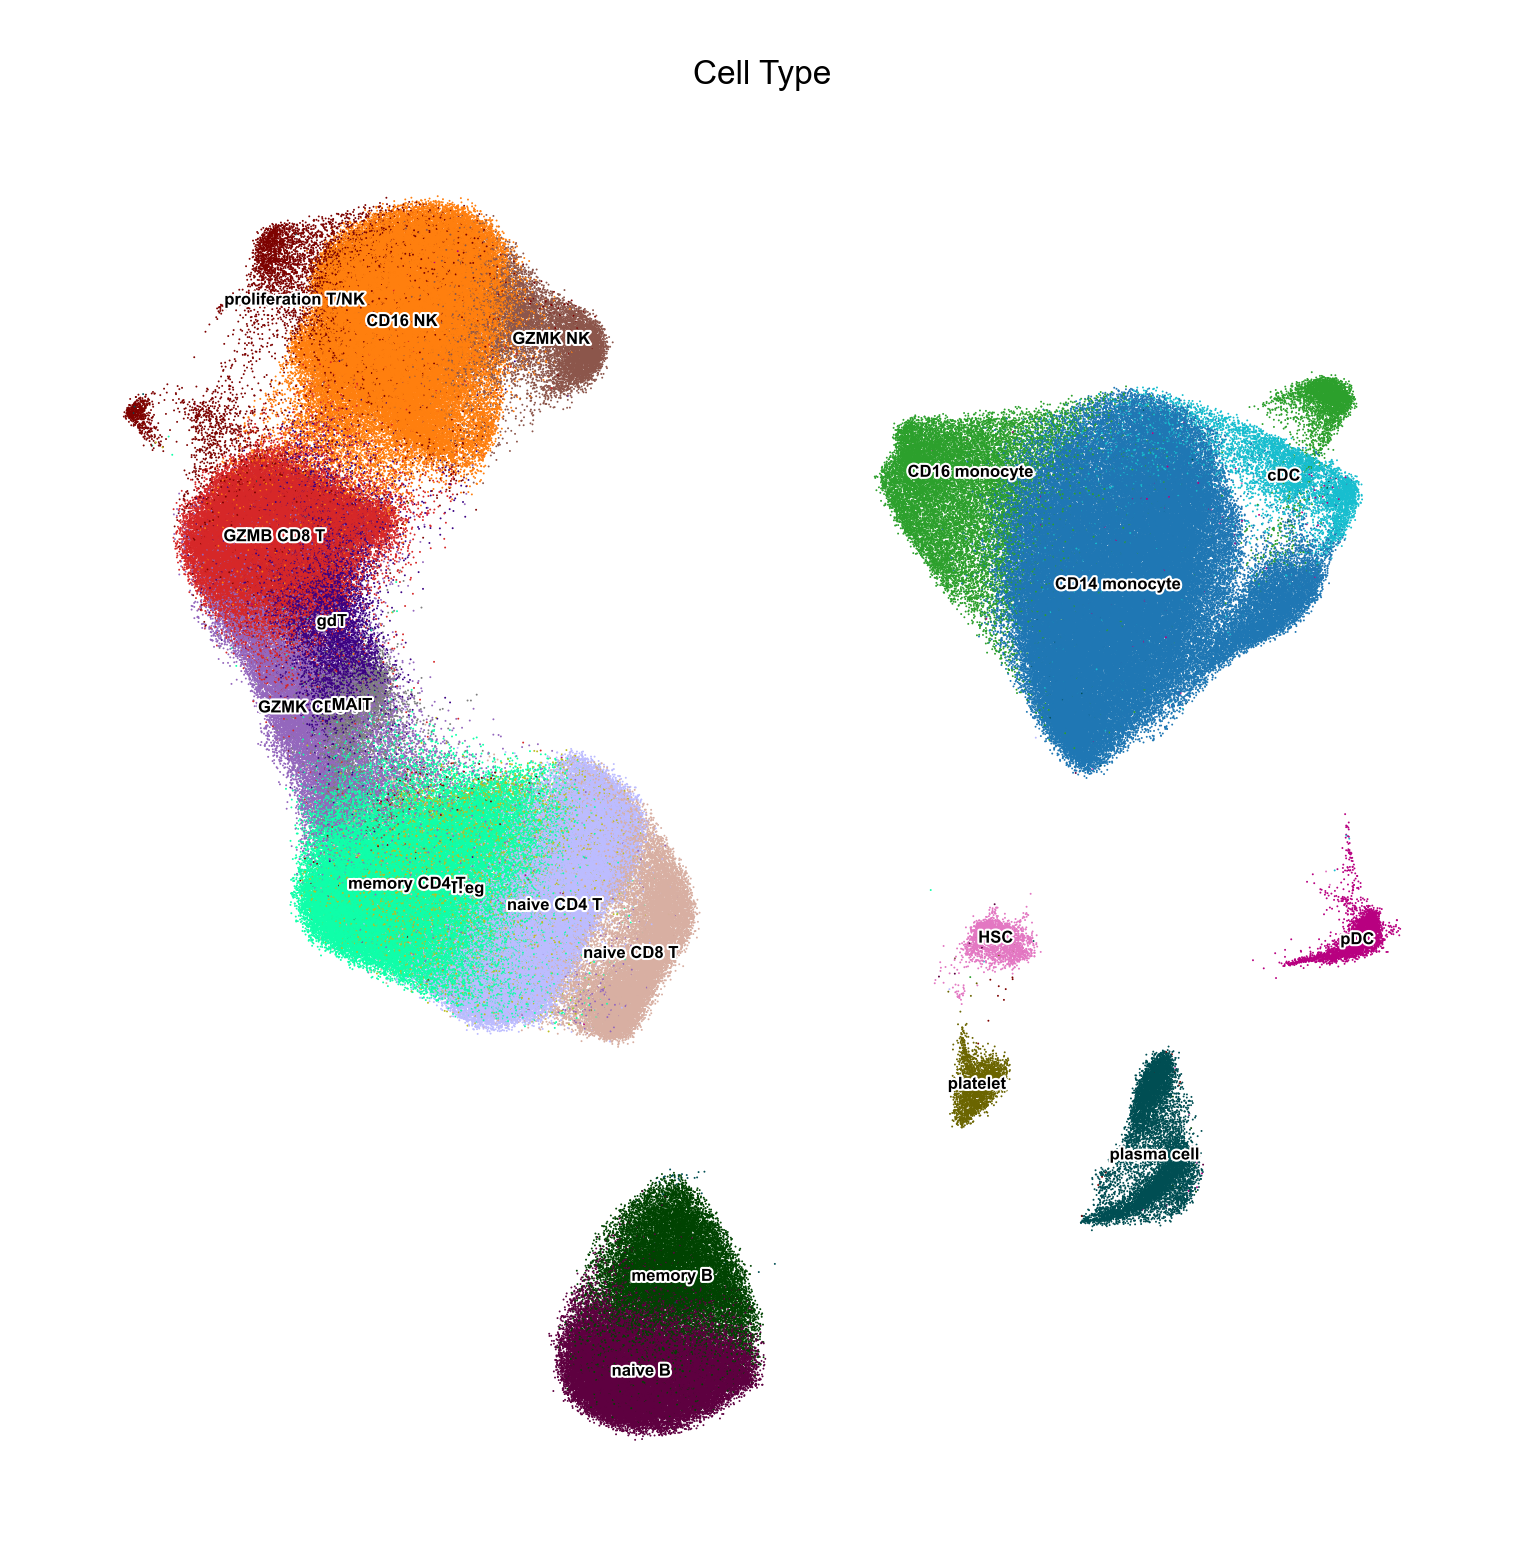

In [84]:
# Generate plot with the legend location on the UMAP
# Generate the UMAP plot
ax = sc.pl.umap(adata, color='CellType', legend_loc='on data',
           frameon=False, legend_fontsize=2, legend_fontoutline=0.5, show=False)

# Set the plot title with the desired font size
ax.set_title('Cell Type', fontsize=4)

# Show the plot
plt.show()

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


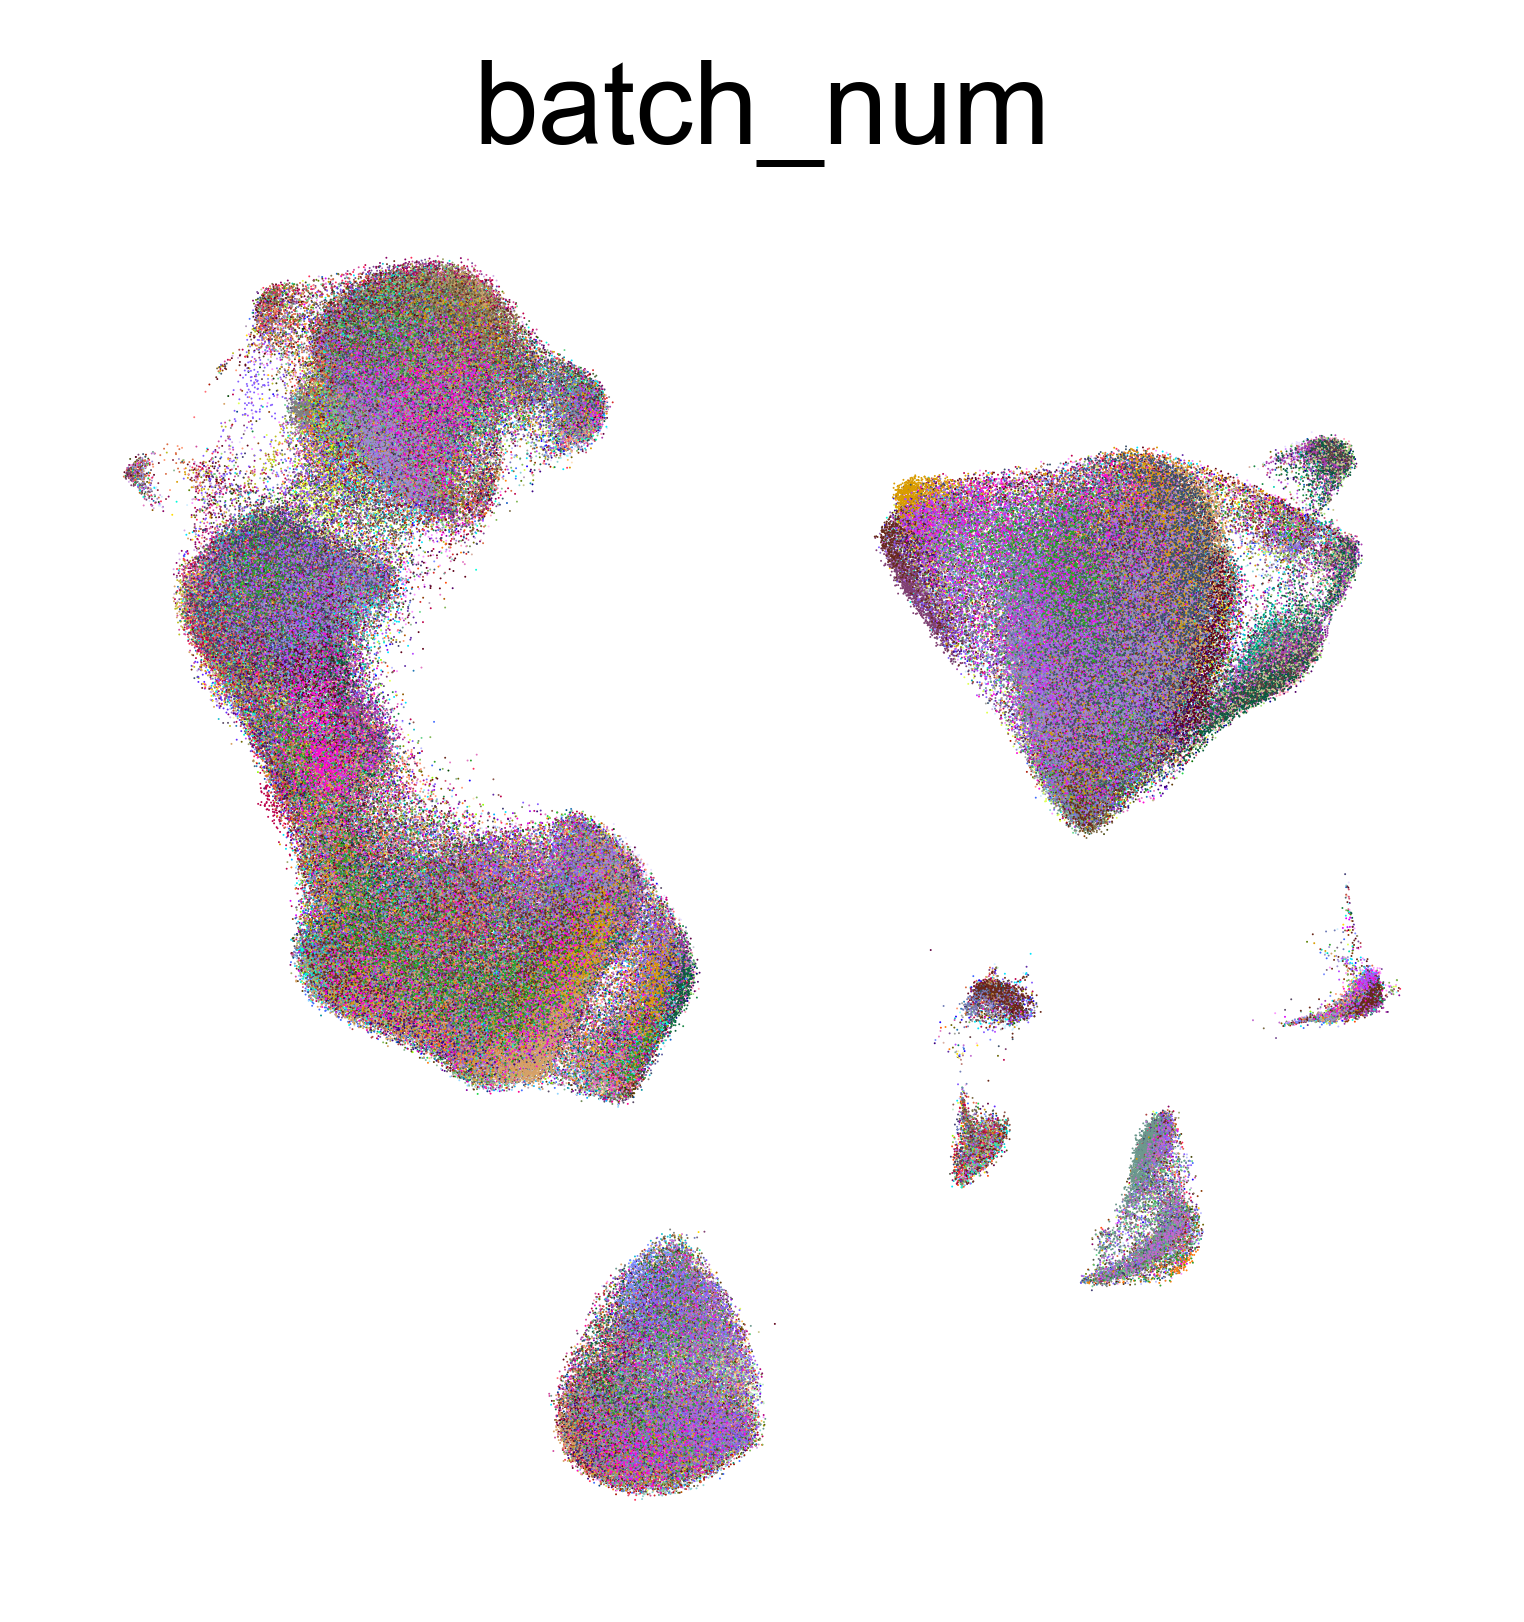

In [85]:
sc.pl.umap(adata, color=["batch_num"], legend_loc = None,
           palette=custom_palette)

/home/rom/miniconda3/envs/genex/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


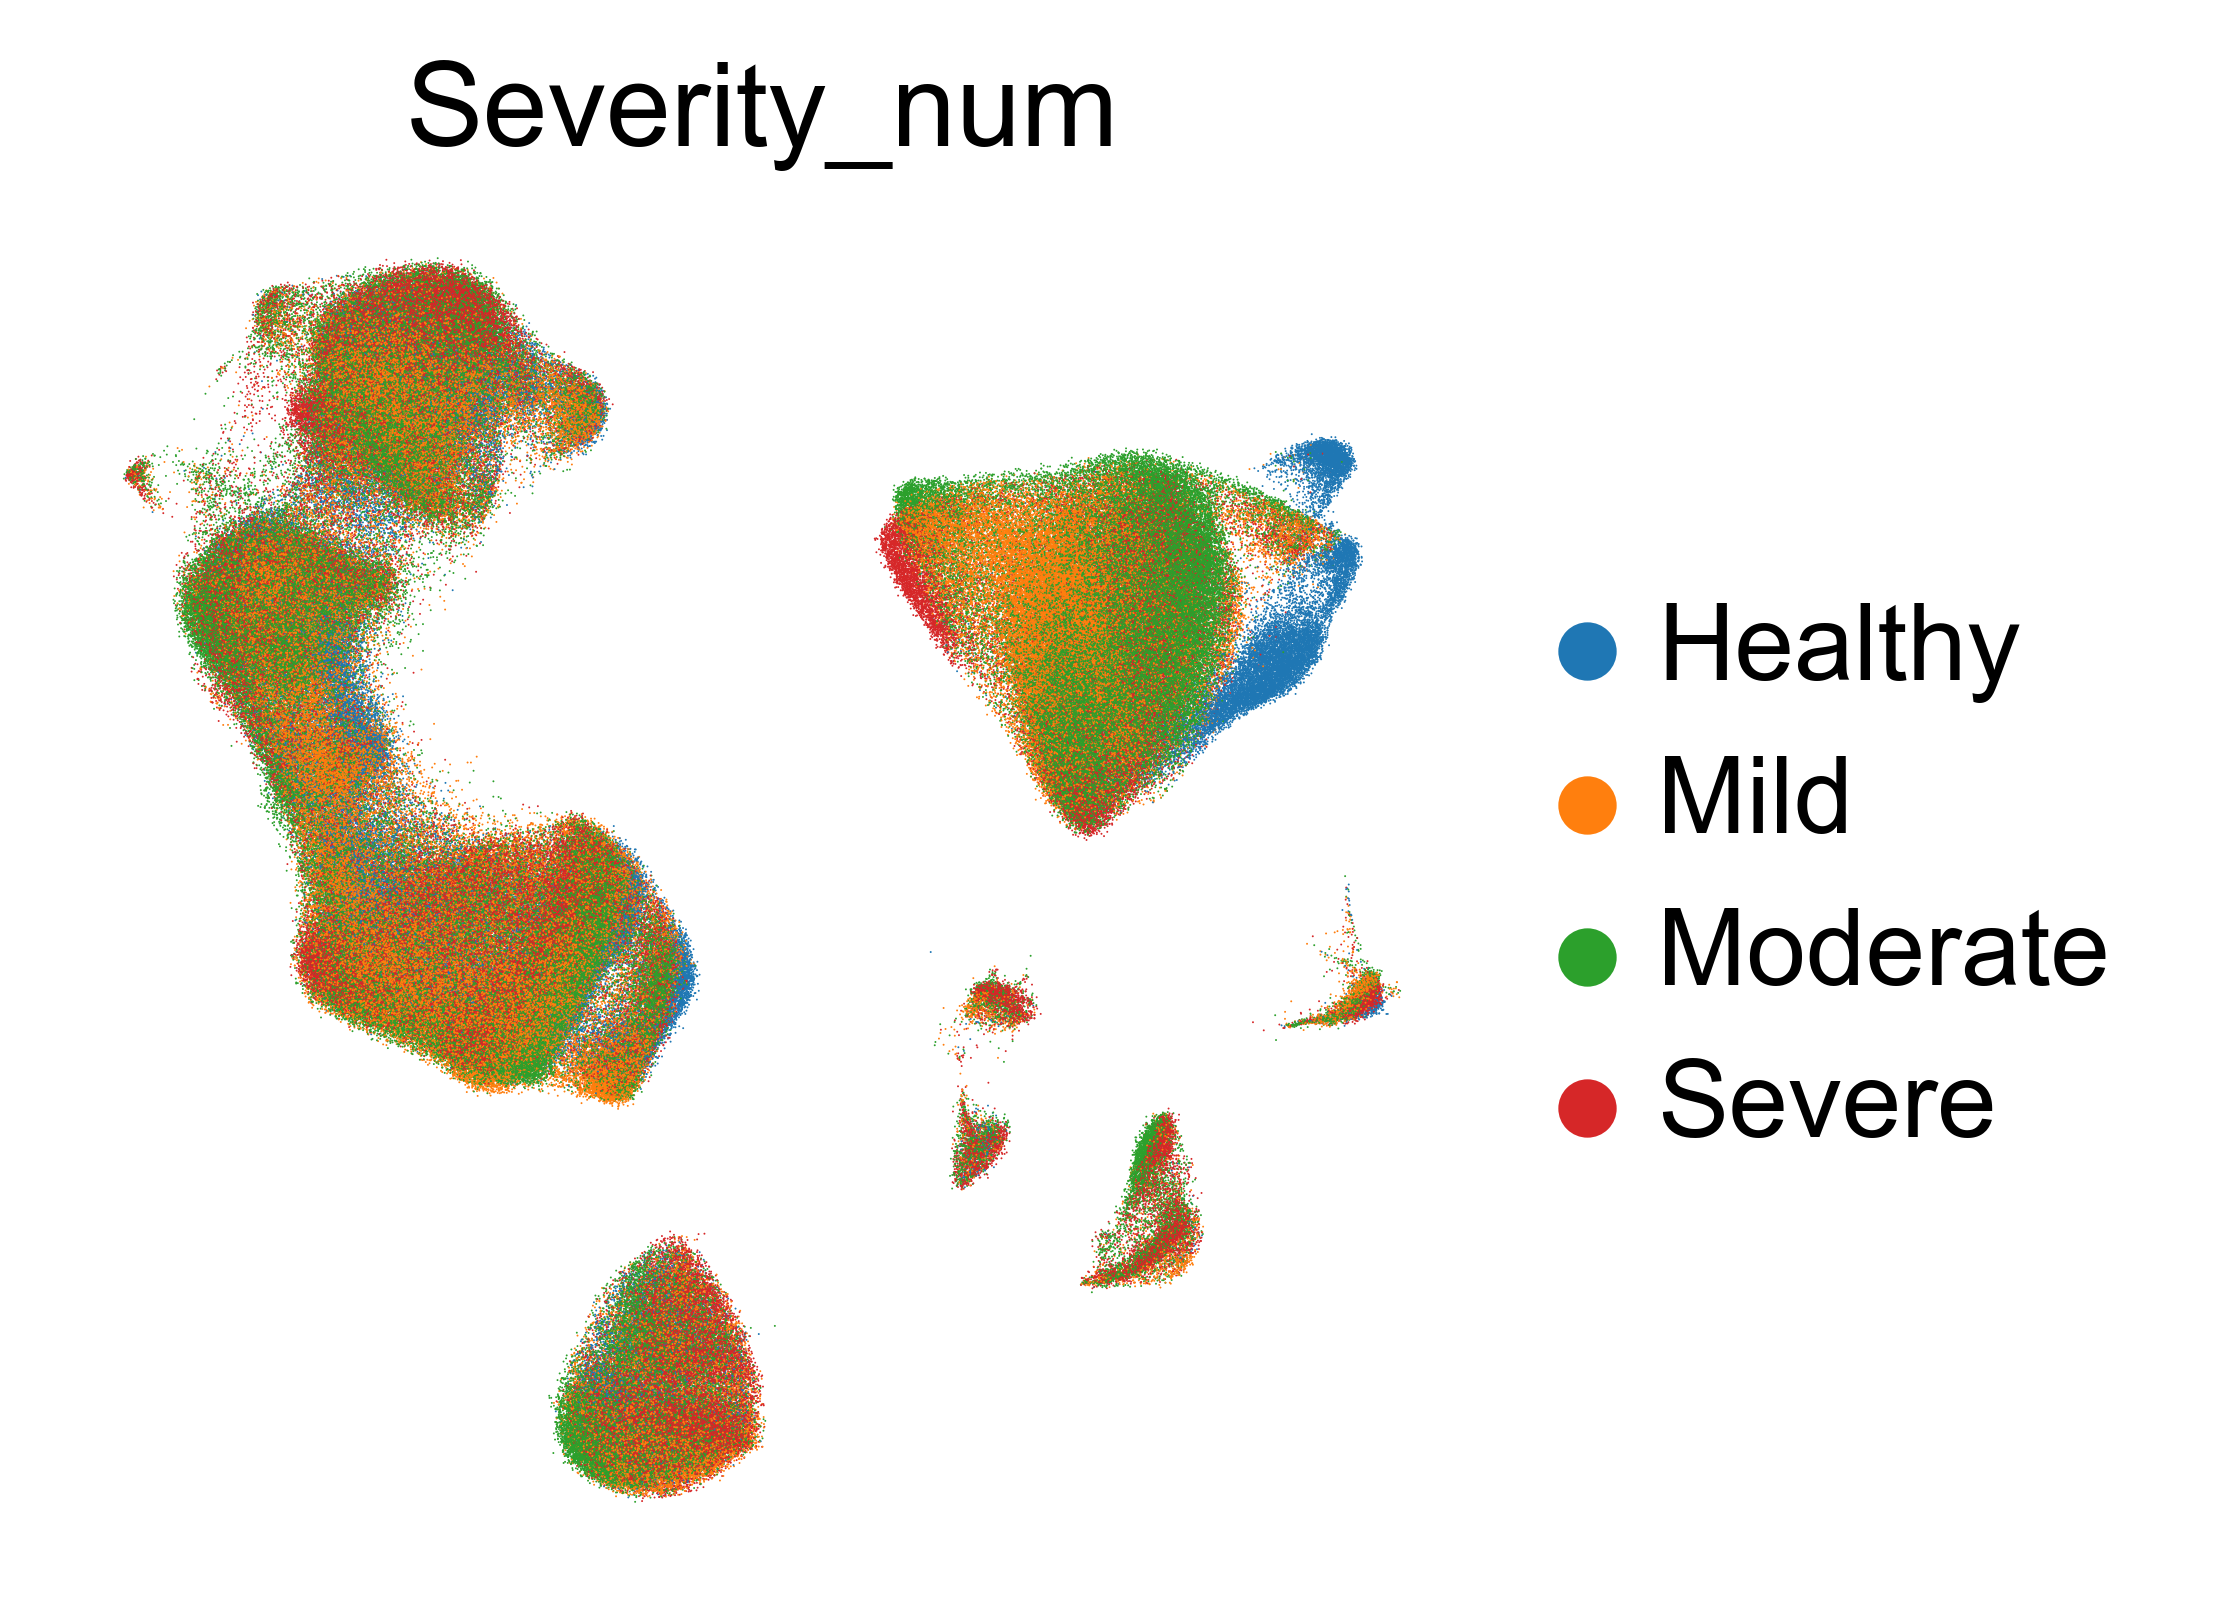

In [86]:
sc.pl.umap(adata, color=["Severity_num"],
           palette=custom_palette)

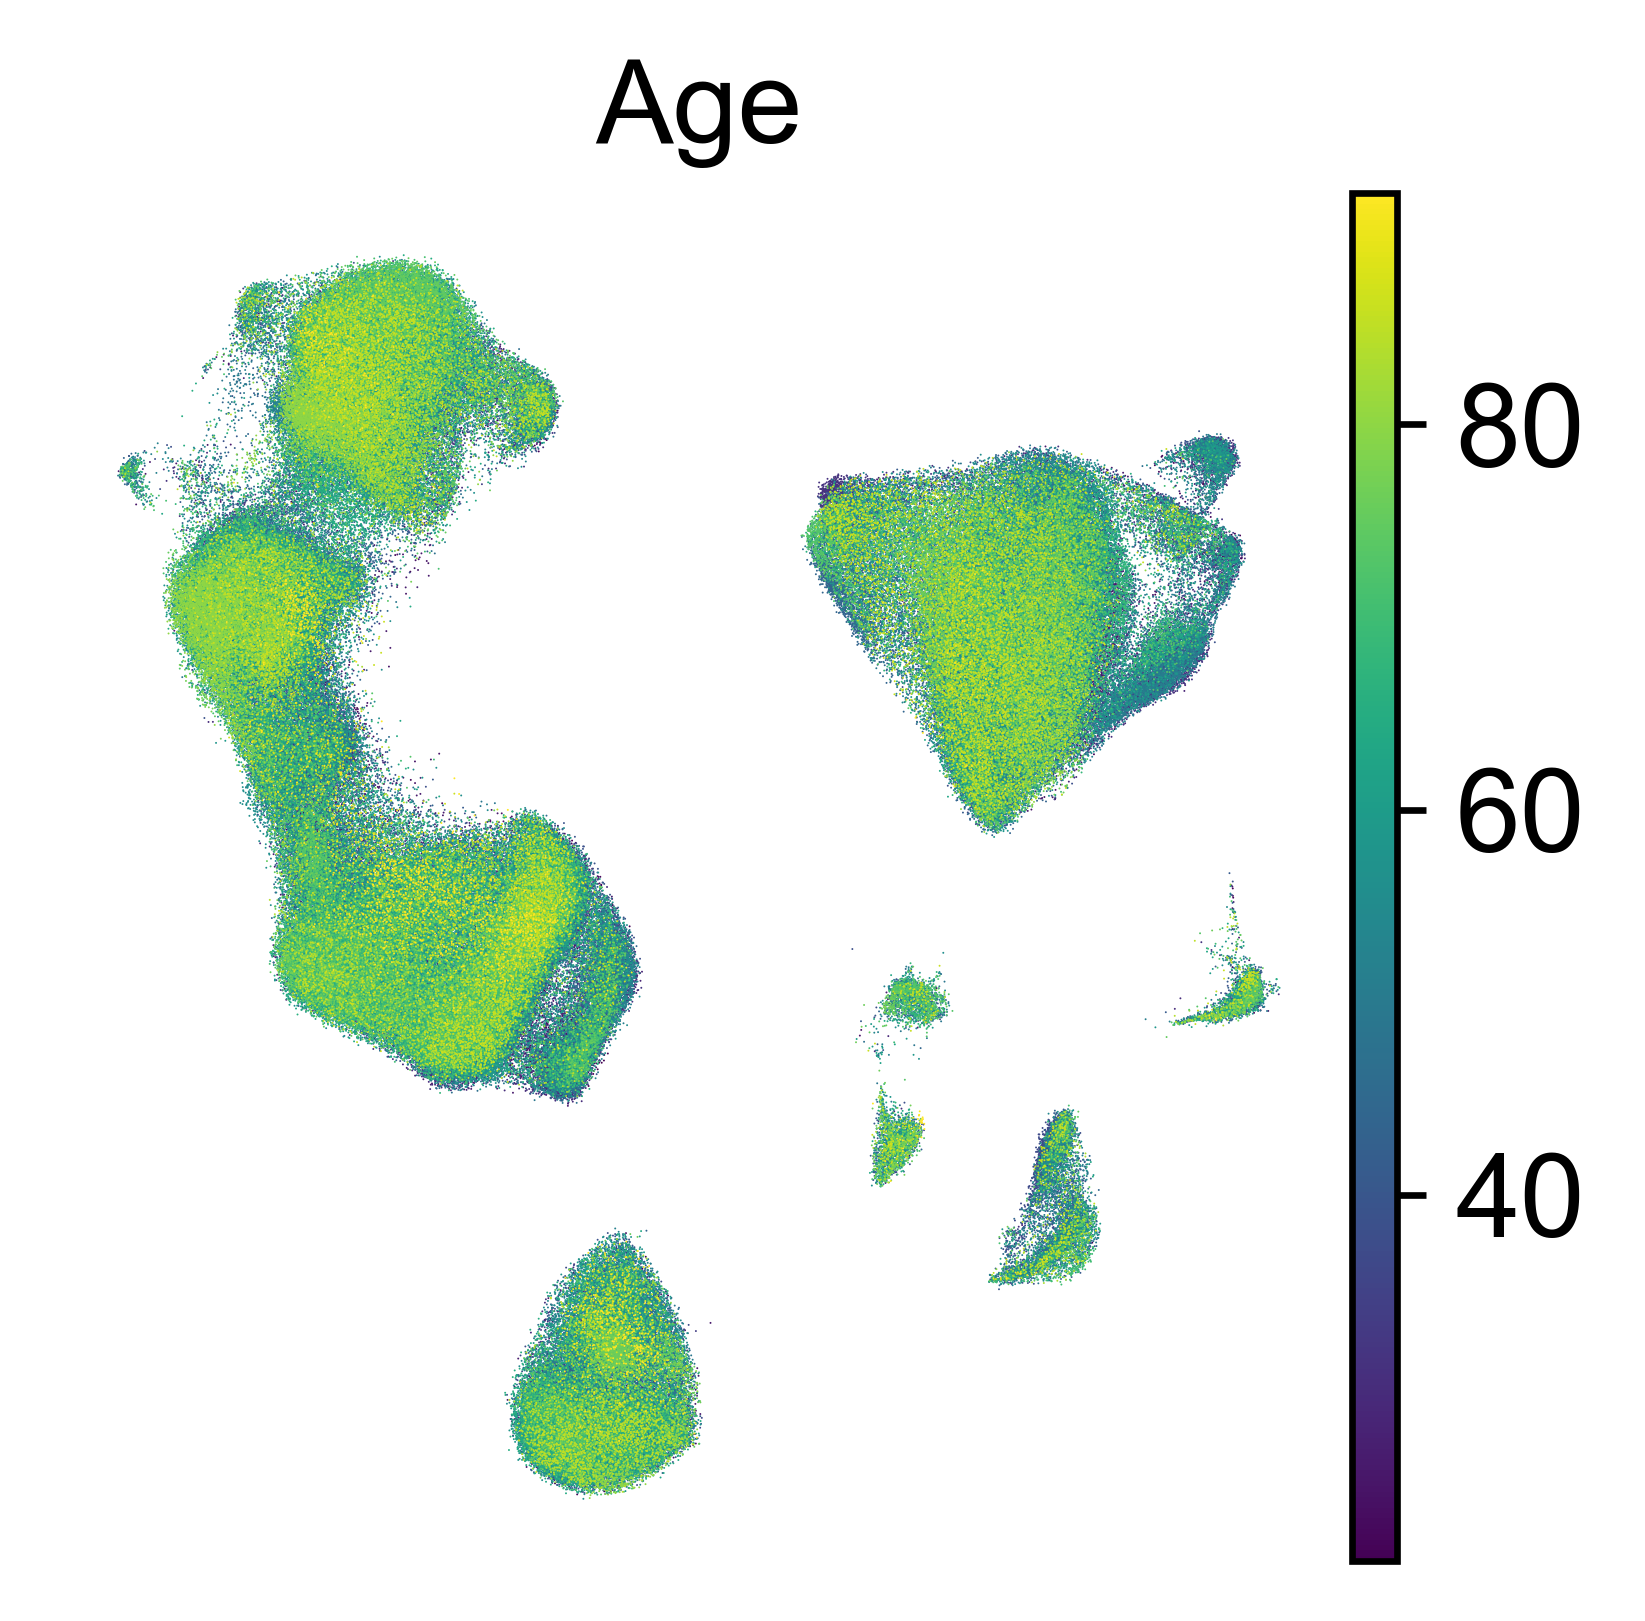

In [87]:
sc.pl.umap(adata, color=["Age"],
           palette=custom_palette)

In [88]:
adata

AnnData object with n_obs × n_vars = 555976 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'ct', 'sample', 'projectID', 'DataID', 'PatientID', 'Disease_Group', 'Severity', 'Stage', 'Age', 'Sex', 'Race', 'Hospital_Day', 'Days_Symotom_Onset', 'Outcome', 'Tissue', 'Frozen', 'Platform', 'WHO.stage', 'City', 'Country', 'Batch', 'CellType', 'batch', 'batch_num', 'Severity_num', 'n_counts'
    var: 'gene'
    uns: 'CellType_colors', 'Severity_num_colors', 'batch_num_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_raw', 'counts', 'log_norm'
    obsp: 'connectivities', 'distances'

In [89]:
# ari = compute_ari(adata)

In [ ]:
# ari

In [92]:
# adata.write_h5ad("rom_model_pbmc(updated).h5ad")
# adata.write_h5ad("genex_COVID.h5ad")

In [ ]:
# clear GPU
import torch
torch.cuda.empty_cache()

In [97]:
# # Define the colorcet paletteasdasd
# custom_palette = cc.glasbey_category10

# ax = sc.pl.umap(adata, color='Severity_num', palette=custom_palette,
#            frameon=False, legend_fontsize=3.5, show=False)

# # Set the plot title with the desired font size
# ax.set_title('Predicted Cell Type', fontsize=6)

# # Adjust the legend font size
# handles, labels = plt.gca().get_legend_handles_labels()

# # Adjust the size of the circles
# for handle in handles:
#     handle.set_sizes([12])
#     handle.set_edgecolor('black')
#     handle.set_linewidth(0.5)

# # Move the legend to the right side of the plot
# plt.legend(handles=handles, labels=labels, prop={'size': 5}, ncol = 4, 
#            loc='upper center', bbox_to_anchor=(0.5, -0.08))

# # Show the plot
# plt.show()